In [1]:
# imports
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
utils.set_random_seed(42)

In [2]:
# loading data
(train_ds, val_ds, test_ds), info = tfds.load(name='tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                              with_info=True, as_supervised=True)

In [3]:
# getting the count of images in each set
print('Train image count:', len(train_ds))
print('Val image count:', len(val_ds))
print('Test image count:', len(test_ds))

Train image count: 2936
Val image count: 367
Test image count: 367


In [4]:
# getting number of classes
num_cls = info.features['label'].num_classes
print(num_cls)

5


In [5]:
# getting class names 
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

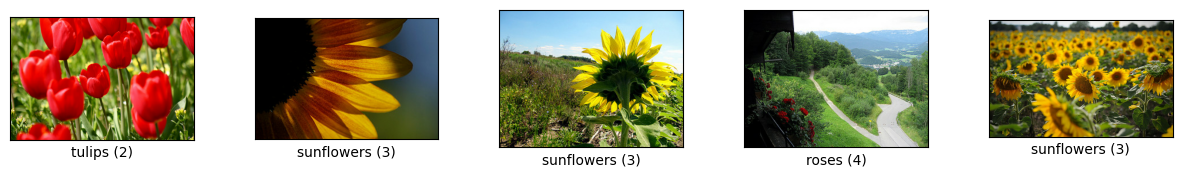

In [6]:
# looking at some images
fig = tfds.show_examples(train_ds, info, rows=1, cols=5)

In [7]:
# preprocessing images
def resize_rescale(image, label):
  image = tf.image.resize(image, (256, 256))
  image = (image / 255.0)
  return image, label
train_ds = train_ds.map(resize_rescale)
val_ds = val_ds.map(resize_rescale)
test_ds = test_ds.map(resize_rescale)

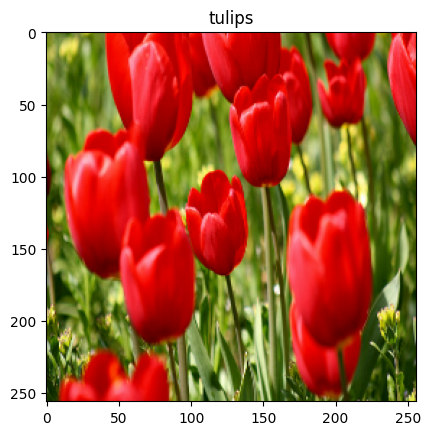

In [8]:
# fetching an image for data augmentation
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [9]:
# defining a function to visualize augmented images
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

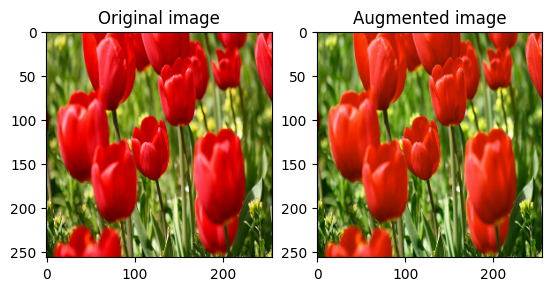

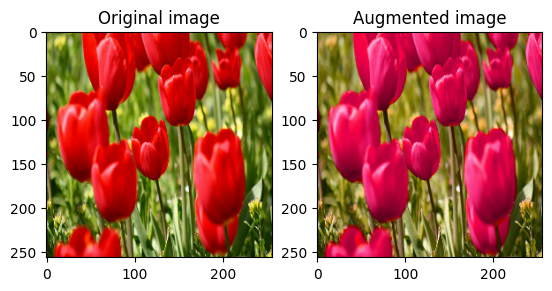

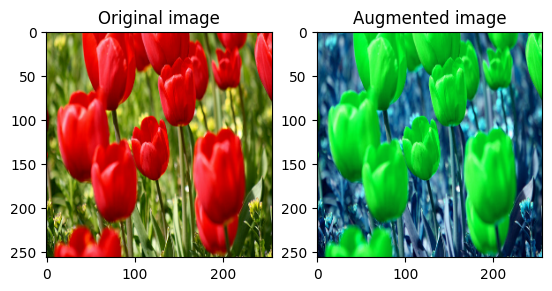

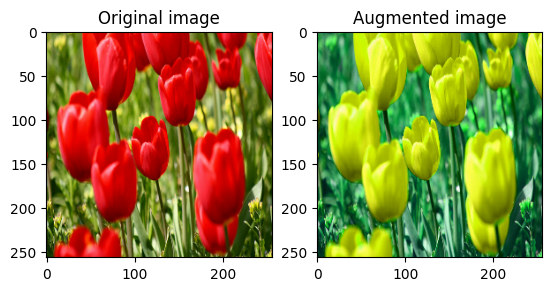

In [10]:
# random hue transformation
for i in range(4):
  augmented_image = tf.image.random_hue(image, max_delta=0.5, seed=32)
  visualize(image, augmented_image)

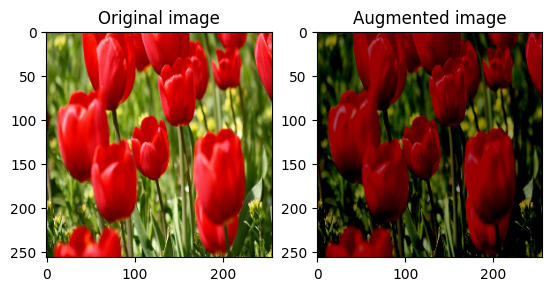

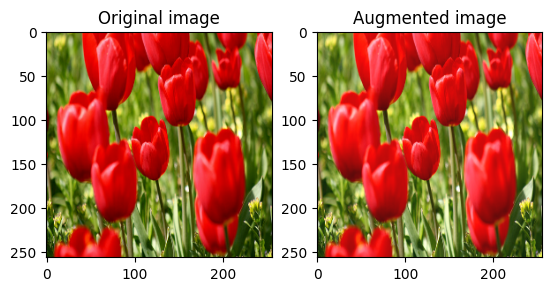

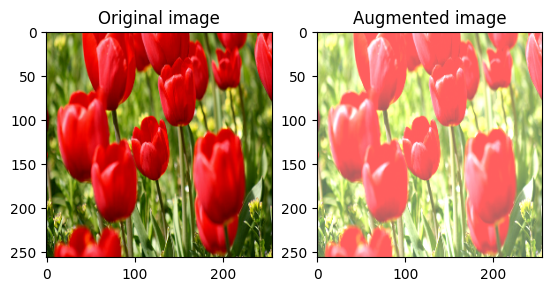

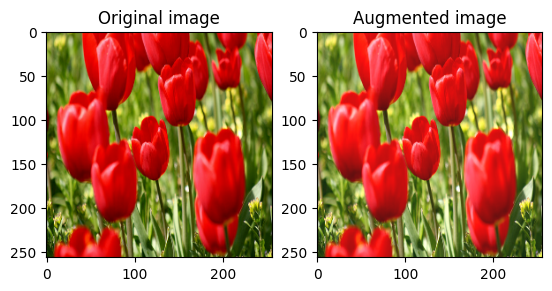

In [11]:
# random brightness transformation
for i in range(4):
  augmented_image = tf.image.random_brightness(image=image, max_delta=0.5, seed=32)
  visualize(image, tf.clip_by_value(augmented_image, 0, 1))

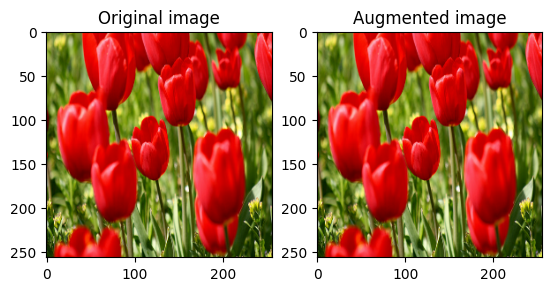

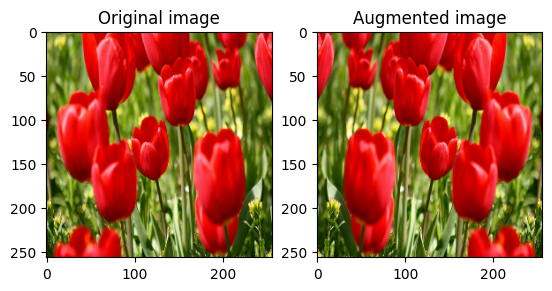

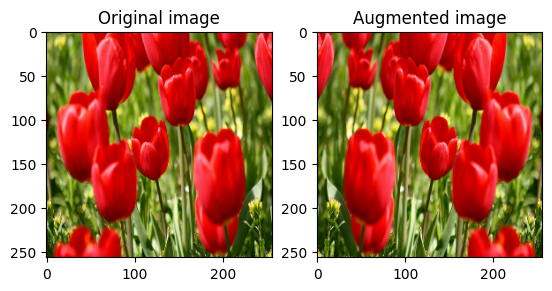

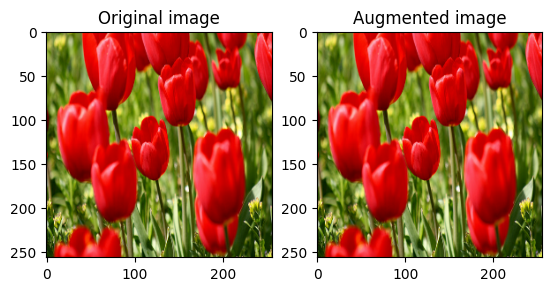

In [12]:
# horizontal flip transformation
for i in range(4):
  augmented_image = tf.image.random_flip_left_right(image, seed=32)
  visualize(image, augmented_image)

**For checking image transformations individually:**
```
# fetching an image for data augmentation
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# defining a function to visualize augmented images
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

# applying tf.image function on the image
flipped = tf.image.random_flip_left_right(image, seed=20)
visualize(image, flipped)
```

In [13]:
# defining a function to apply the above transformations on dataset
def augment(image, label):
  image = tf.image.random_hue(image=image, max_delta=0.5, seed=32)
  image = tf.image.random_brightness(image=image, max_delta=0.5, seed=32)
  image = tf.image.random_flip_left_right(image=image, seed=32)
  return image, label

In [14]:
# applying the function on training set
train_ds = train_ds.map(augment)

In [15]:
# building input pipeline
train_ds = train_ds.shuffle(len(train_ds)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# model building
model = Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(rate=.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_cls, activation='softmax')
])

In [17]:
# model summary
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 128, 128, 16)     0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                        

In [18]:
# model config
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# model training
history = model.fit(train_ds, validation_data=val_ds, epochs=2, verbose=1)

Epoch 1/2
92/92 [==============================] - 29s 79ms/step - loss: 1.6395 - accuracy: 0.2670 - val_loss: 1.5141 - val_accuracy: 0.4005
Epoch 2/2
92/92 [==============================] - 4s 45ms/step - loss: 1.4545 - accuracy: 0.3621 - val_loss: 1.3518 - val_accuracy: 0.4114


In [20]:
# model accuracy
scores = model.evaluate(test_ds, verbose=0)
print('Accuracy:', round(scores[1] * 100, 2))

Accuracy: 38.15
